In [284]:
import pandas as pd
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
warnings.filterwarnings("ignore")

### Lectura de Archivos

In [285]:
claim=pd.read_excel('../Archivos/claim.xlsx')
service=pd.read_excel('../Archivos/service.xlsx')
status=pd.read_excel('../Archivos/status.xlsx')
status_type=pd.read_excel('../Archivos/status_type.xlsx')
status_cause=pd.read_excel('../Archivos/status_cause.xlsx')
people=pd.read_excel('../Archivos/people.xlsx')
dict_data=pd.read_excel('../Archivos/Diccionario de Datos.xlsx')

### Creación de columna 'updated_day' con la fecha en formato (Y/M/D)

In [286]:
#Obtener una columna con la fecha de su 'updated_at'
def tiempo(archivo):
    archivo['updated_at'] = pd.to_datetime(archivo['updated_at'], errors='coerce')
    archivo['updated_day'] = archivo['updated_at'].dt.strftime('%Y-%m-%d').astype('period[D]')
    return archivo

In [287]:
claim = tiempo(claim)
service = tiempo(service)
status = tiempo(status)
status_type = tiempo(status_type)
status_cause = tiempo(status_cause)
people = tiempo(people)

### Función que permite calcular el amount final a un servicio que tiene coberturas que aplican según dispongamos y si aplica deducible (deductible = True)

In [288]:
def buscar_y_actualizar(df_service, df_status, patrones, commercial_value, porcentaje_aumento):
    '''
    Función para modificar los valores in situ de la columna amount donde 
    aplica cobertura las coberturas que ingresemos en la lista patrones y 
    donde la columna deductible es True. 
    '''
    # Buscar por patrones en la columna 'description' de 'status'
    ids = []
    for patron in patrones:
        df_status['description'] = df_status['description'].fillna('')
        filtro = df_status['description'].str.contains(patron, case=False, regex=True)
        resultados = df_status[filtro].reset_index(drop=True)

        # Obtener id para filtrar las columnas en la tabla 'service'
        if not resultados.empty:
            coverage_id = resultados['id'][0]
            ids.append(coverage_id)

    # Filtrar las filas que cumplen con el deducible y las coberturas específicas en 'service_c'
    deducible_true_rows = df_service[(df_service['deductible'] == True) & (df_service['coverage_id'].isin(ids))]

    # Calcular el aumento en la columna 'amount'
    aumento = porcentaje_aumento * commercial_value
    df_service.loc[deducible_true_rows.index, 'amount'] += aumento

### Consulta 1

¿Cuál es la siniestralidad mensual de la compañía? 

- Asumir que las primas devengadas en cada mes (ingreso mensual) corresponden a 200k pesos por mes.
- Para los gastos de cada siniestro, usar la columna `amount` de `service`. Si el signo es negativo, indica que es un gasto, en caso contrario es un ingreso.
- En caso de que no exista `amount` en el servicio, ignorar el servicio para el cálculo de la siniestralidad.
- La columna `deductible` en `service` indica si hay o no que aplicarse deducible para el servicio.
- Asumir que el deducible para las coberturas de daños materiales y robo total es de 5% sobre 100k del valor comercial del auto.
- En caso de que el servicio no tenga cobertura asociada o status `no aplica`, hacer el análisis sin deducible.

Consideraciones tomadas:

Siniestralidad se refiere a la relación entre los gastos por siniestros ocurridos durante un período específico y el total de primas o ingresos percibidos en el mismo período.

Si el vehículo está asegurado con ambas coberturas y presenta un siniestro que involucra tanto robo total como daños materiales, el asegurado tendría que pagar un deducible por cada una de estas coberturas:

-Deducible para robo total: Se especifica como el 5% sobre 100k del valor comercial del auto.

-Deducible para daños materiales: También se especifica como el 5% sobre 100k del valor comercial del auto.

In [289]:
#Copias para no alterar las tablas para los siguientes cálculos:
service_c=service.copy()

In [290]:
#Quitando servicios donde no hay "amount":
service_c.dropna(subset=['amount'], inplace=True)

In [291]:
# Definir patrones, valor comercial del auto y porcentaje de la póliza.
patrones = ["Robo Total", "Daños materiales"]
commercial_value = 100000
porcentaje_aumento = 0.05

# Llamar a la función para buscar y actualizar en 'service_c'
buscar_y_actualizar(service_c, status, patrones, commercial_value, porcentaje_aumento)

In [292]:
#Sumando por mes el monto de gastos e ingresos. 
pd.options.display.float_format = '{:,.2f}'.format
result = service_c.groupby(service_c['updated_at'].dt.to_period("M")).agg({'amount': 'sum'})
#Incorporar la columna de prima devengada
result['primas_devengadas']=200000
#Calculo de la Siniestralidad_Mensual
result['Siniestralidad_Mensual']=result['amount']+result['primas_devengadas']

In [293]:
result

,amount,primas_devengadas,Siniestralidad_Mensual
updated_at,,,
2023-06,"4,347,211.00",200000,"4,547,211.00"
2023-07,"-64,131,564.00",200000,"-63,931,564.00"
2023-08,"-270,823,091.00",200000,"-270,623,091.00"
2023-09,"-288,368,385.00",200000,"-288,168,385.00"
2023-10,"-3,314,836,200.00",200000,"-3,314,636,200.00"
2023-11,"-689,602,689.00",200000,"-689,402,689.00"


##### Gráfico para llenar el reporte en PDF

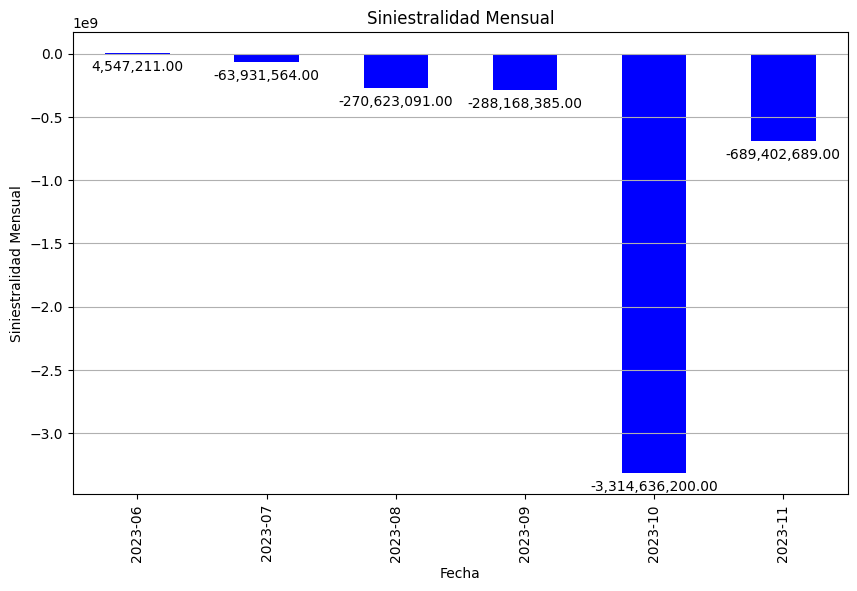

In [294]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = result['Siniestralidad_Mensual'].plot(kind='bar', color='blue')

# Personalizar el gráfico
plt.title('Siniestralidad Mensual')
plt.xlabel('Fecha')
plt.ylabel('Siniestralidad Mensual')
plt.grid(axis='y')

# Mostrar las cantidades sobre las barras
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, -10), textcoords='offset points')
plt.savefig('Siniestralidad_Mensual.png')
# Mostrar el gráfico
plt.show()

In [295]:
#Para usarlo en el PDF
result['Siniestralidad_Mensual'] = result['Siniestralidad_Mensual'].apply(lambda x: f'{x:,.2f}')

### Consulta 2

- ¿Cuál es la cobertura con mayor y menor cantidad de siniestros?

Consideraciones:
Un siniestro puede tener diferentes coberturas en el mismo evento.

In [296]:
#De la tabla status traemos el tipo de coberturas y lo cruzamos con los diferentes
#siniestros que tienen algún tipo de cobertura en la tabla service.
result_=pd.merge(left=service,right=status,left_on='coverage_id',right_on='id')
#Obtener cuantos siniestros están identificados con las coberturas:
result_.shape

(447, 22)

In [297]:
#Agrupar por tipo de cobertura y sumar los siniestros.
result_=result_.groupby(['coverage_id', 'name', 'description_y']).size().reset_index(name='Siniestros').sort_values('Siniestros',ascending=False)
result_=result_.reset_index(drop=True)
result_

,coverage_id,name,description_y,Siniestros
0,c2b3cdd7-2c89-4d92-aa04-6b343ad91425,DM,Daños materiales,220
1,d348e5c4-1e27-45ca-b261-4e72c116c957,No Aplica,Servicios que no afectan a las reservas,73
2,6c434f2a-d0f3-4442-b4c5-6680ec0fda6d,GM,Gastos medicos,49
3,fa67b067-ffdf-431b-aef5-53e60dfe6be6,RCB,Responsabilidad civil bienes,40
4,ca2ead83-5b81-4480-9a0b-744ba31601c0,AL,Asistencia legal,20
5,ed22aeaf-8623-4d4d-ad59-106a774ed9a5,AV,Asistencia vial,19
6,42d81165-f6f7-4c0d-b33b-999a3f3ee905,RCP,Responsabilidad civil personas,18
7,fc9e6248-5746-4480-a9d0-d683cb6a6c10,RT,Robo total,8


In [298]:
mayor_cantidad_siniestros=result_[result_['Siniestros'] == result_['Siniestros'].max()]
menor_cantidad_siniestros=result_[result_['Siniestros'] == result_['Siniestros'].min()]
print('Mayor Cantidad:\n',mayor_cantidad_siniestros)
print('\nMenor Cantidad:\n',menor_cantidad_siniestros)

Mayor Cantidad:
                             coverage_id name     description_y  Siniestros
0  c2b3cdd7-2c89-4d92-aa04-6b343ad91425   DM  Daños materiales         220

Menor Cantidad:
                             coverage_id name description_y  Siniestros
7  fc9e6248-5746-4480-a9d0-d683cb6a6c10   RT    Robo total           8


##### Gráfico para llenar el reporte en PDF

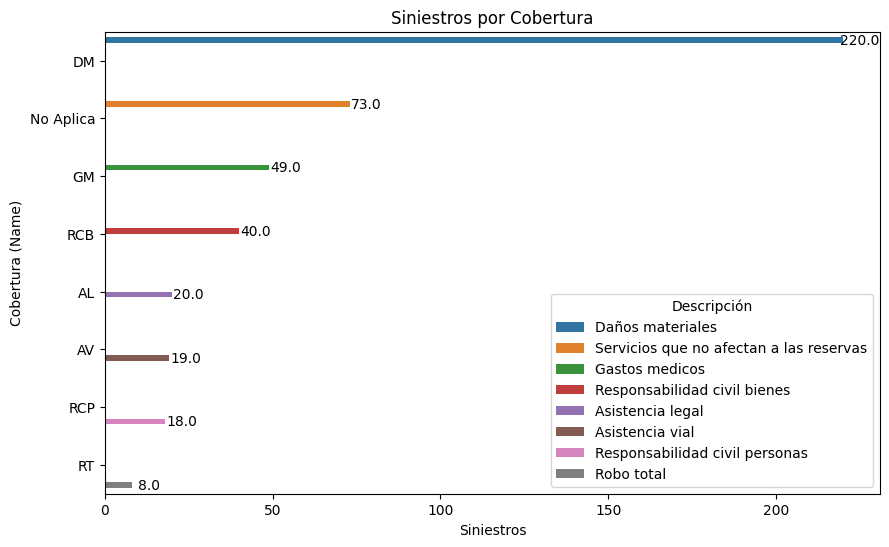

In [299]:
# Crear la gráfica de barras horizontales
plt.figure(figsize=(10, 6))
ax=sns.barplot(x='Siniestros', y='name', data=result_, hue='description_y')

# Añadir etiquetas y título
plt.xlabel('Siniestros')
plt.ylabel('Cobertura (Name)')
plt.title('Siniestros por Cobertura')

# Mostrar la leyenda
plt.legend(title='Descripción')
# Añadir números a cada barra

for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_x() + p.get_width() + 5, p.get_y() + p.get_height() / 2), ha='center', va='center')
#Save

plt.savefig('Siniestros.png')
# Mostrar la gráfica
plt.show()

### Consulta 3

- ¿Cuál es el partner con mayor y menor siniestralidad? 
    - Asumir que el deducible para las coberturas de daños materiales y robo total es de 5% sobre 100k del valor comercial del auto.
    - El partner se puede identificar con las primeras dos letras de `policy_number` dentro de `claim`,  por ejemplo "KV", “AE”, “IT”, etc.

Consideraciones: 
-Siniestralidad se refiere a la relación entre los gastos por siniestros ocurridos durante un período específico y el total de primas o ingresos percibidos en el mismo período.

-Se excluyen los servicios con monto cero (después de verificar si aplica un deducible por la cobertura o no). La siniestralidad se está evaluando en términos de costos reales para CRABI, por lo que centrarse solo en los servicios que generan costos da una visión más precisa de la siniestralidad.

Ya que no hay conexión directa entre id's de las tablas "claim" (policy_number) y "service" (amount) se relacionan con el identificador de la tabla "people" por lo que se hará una unión entre las tablas people(claim_id) y claim (id), para después poder usar los identificadores de policy_number, con la tabla service.

In [300]:
service_c1=service.copy()
service_c1.dropna(subset=['amount'], inplace=True)
service_c1=service_c1.reset_index(drop=True)

In [301]:
#Unión de Tablas
merged_df = pd.merge(left=claim, right=people, left_on='id', right_on='claim_id')
result_merge=pd.merge(left=service_c1,right=merged_df,left_on='people_id',right_on='id_y')
result_merge.shape

(452, 59)

In [302]:
# Definir patrones, valor comercial del auto y porcentaje de la póliza.
patrones2 = ["Robo Total", "Daños materiales"]
commercial_value2 = 100000
porcentaje_aumento2 = 0.05

# Llamar a la función para buscar y actualizar en 'result_merge'
buscar_y_actualizar(result_merge, status, patrones2, commercial_value2, porcentaje_aumento2)

In [303]:
#Realizando la suma del costo de los siniestros agrupados por el identificador de póliza
#El siniestro tiene un partner asignado hasta su cierre, por lo que se puedo realizar la
#suma de los siniestros directamente.
result2 = result_merge.groupby(result_merge['policy_number'].str.slice(0, 2)).agg({'amount': 'sum'})
result2.sort_values('amount',ascending=False,inplace=True)

In [304]:
result2

,amount
policy_number,
WO,"-1,200,080.00"
DA,"-20,232,068.00"
CH,"-27,180,598.00"
SE,"-40,581,751.00"
KV,"-117,466,114.00"
IT,"-1,868,809,582.00"
AE,"-2,547,944,525.00"


##### Gráfico para llenar el reporte en PDF

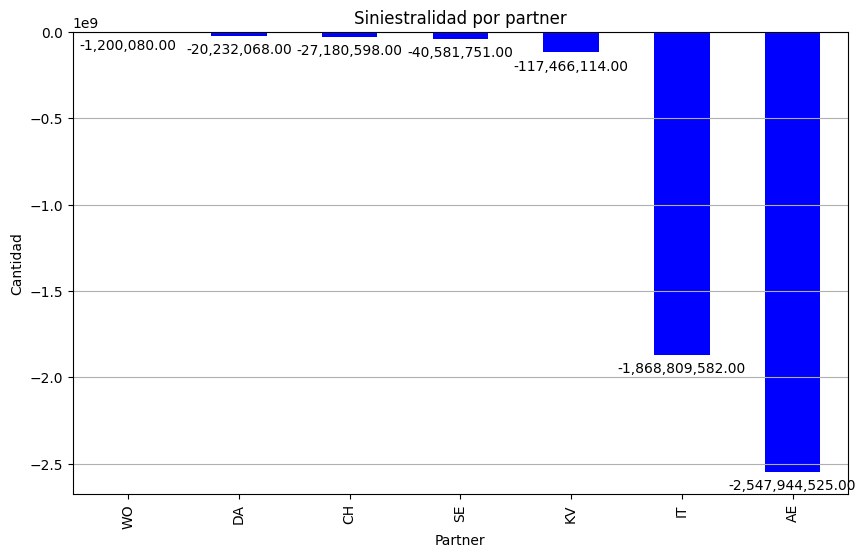

In [305]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = result2['amount'].plot(kind='bar', color='blue')

# Personalizar el gráfico
plt.title('Siniestralidad por partner')
plt.xlabel('Partner')
plt.ylabel('Cantidad')
plt.grid(axis='y')

# Mostrar las cantidades sobre las barras
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, -10), textcoords='offset points')
plt.savefig('Siniestralidad_Partner.png')
# Mostrar el gráfico
plt.show()

In [306]:
#Para usarlo en el PDF
menor_sinestrialidad=result2.head(1)
mayor_sinestrialidad=result2.tail(1)

#### Consulta 3.1

¿cuál es su severidad promedio?

- Asumir que el deducible para las coberturas de daños materiales y robo total es de 5% sobre 100k del valor comercial del auto.

Consideraciones: 

-Severidad: es la sumatoria de todos los gastos del siniestro, después de restar los deducibles a los que aplique según las coberturas involucradas en el siniestro.

-Excluir valores donde el amount sea NaN o Cero: 

Se toma esta postura para calcular un promedio de severidad que se centre solo en los siniestros que generan costos reales. Esto da un promedio más específico en términos de costos financieros directos asociados a los siniestros por tipo de partner.

Entonces ¿Cómo se calculara la "severidad promedio" por partner?, esto sería la suma de todos los gastos del siniestro asociados con un tipo de partner, por lo que no se deben tomar en cuenta servicios con "amount" igual a 0 o NaN, porque no representan un gasto pero si puede afectar el promedio obtenido.

Sev_Prom_Por_Partner= Σ n Sev_Por_Siniestro_Asociado_al_Partner / Siniestros_Asociados_al_Partner

n=Partners

Donde:

Sev_Por_Siniestro_Asociado_al_Partner = Σ n Gasto_X_Siniestro

n=Siniestro_asociados_al_partner


###### Este es un enfoque que puede modificarse a consideración de querer saber, ¿cual es el promedio de gastos por tipo de partner de acuerdo al número de servicios ofertados?

In [307]:
#Aquí ya se tiene los gastos de siniestros con la suma del deducible aplicado 
#únicamente en coberturas de daños materiales y robo total.
result_merge_aux=result_merge.copy()

In [308]:
#Eliminamos servicios con monto igual con cero para no afectar el promedio:
result_merge_aux = result_merge_aux[result_merge_aux['amount'] != 0].reset_index(drop=True)

In [309]:
#Nos quedamos con los identificadores de partners
result_merge_aux['policy_number']=result_merge_aux['policy_number'].str.slice(0,2)

In [310]:
#Se obtiene la suma del siniestro agrupado por people_id y su respectiva póliza.
result_policy = result_merge_aux.groupby(['people_id', 'policy_number'])['amount'].sum().reset_index()
result_policy.shape

(252, 3)

In [311]:
result_policy

,people_id,policy_number,amount
0,0188b6c3-f2b0-7b44-99fb-0d8a80ea2b0b,CH,"-217,500.00"
1,0188d409-b46c-77e0-9458-268ea6243326,CH,"222,300.00"
2,0188d449-ef80-70e6-a2a9-f292f34c705d,KV,"2,977,255.00"
3,0188da6f-3617-7501-b61c-13d0bc6a0cc8,CH,"1,212.00"
4,0188dd2c-5b83-7e1d-b0e4-2686cbf97b8f,AE,"1,003.00"
...,...,...,...
247,018b8321-75fc-7f53-a73b-1dba90476bc4,AE,"-1,000,000.00"
248,018b8869-192f-7cdd-8881-f5d9c13bd20e,IT,"-595,000.00"
249,018b89e8-de6d-7d01-bf33-a79702b16b1f,AE,"-685,289,600.00"
250,018b9116-aee7-7744-9498-cb8d2f4f8aa7,KV,"-495,000.00"


In [312]:
#Comprobación de que tenemos para cada 'people_id' un tipo de partner.
result_policy['people_id'].nunique()

252

In [313]:
result_pattern_avg = result_policy.groupby('policy_number')['amount'].mean().reset_index()

In [314]:
result_pattern_avg.sort_values('amount').reset_index(drop=True)

,policy_number,amount
0,IT,"-88,990,932.48"
1,AE,"-21,232,871.04"
2,SE,"-8,116,350.20"
3,KV,"-1,779,789.61"
4,DA,"-1,556,312.92"
5,WO,"-1,200,080.00"
6,CH,"-1,045,407.62"


##### Gráfico para llenar el reporte en PDF

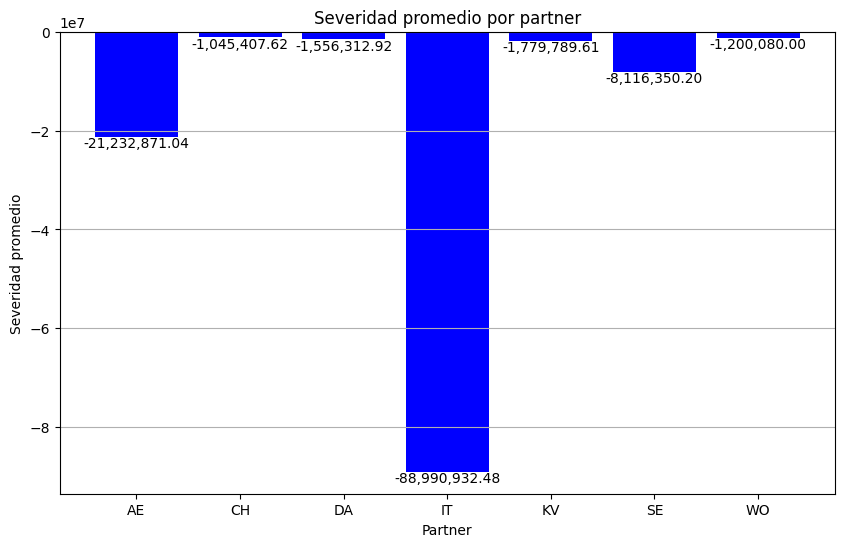

In [315]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = plt.bar(result_pattern_avg['policy_number'], result_pattern_avg['amount'], color='blue')

# Personalizar el gráfico
plt.title('Severidad promedio por partner')
plt.xlabel('Partner')
plt.ylabel('Severidad promedio')
plt.grid(axis='y')

# Función para agregar etiquetas de valores en las barras
def autolabel(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval,
                 f'{yval:,.2f}',
                 ha='center', va='bottom' if yval > 0 else 'top', color='black')

# Agregar etiquetas de valores en las barras
autolabel(ax)

# Mostrar el gráfico
plt.savefig('Siniestralidad_Promedio_Partner.png')
plt.show()

In [316]:
#Para usarlo en el PDF
prom_partner_min=result_pattern_avg[result_pattern_avg['policy_number']== menor_sinestrialidad.index[0]]
prom_partner_min['amount'] = prom_partner_min['amount'].apply(lambda x: f'{x:,.2f}')
prom_partner_max=result_pattern_avg[result_pattern_avg['policy_number']== mayor_sinestrialidad.index[0]]
prom_partner_max['amount'] = prom_partner_max['amount'].apply(lambda x: f'{x:,.2f}')

### Consulta 4

- Utilizando los datos de la tabla `people`, ¿dentro de qué rango etario se encuentra la mayor y menor cantidad de usuarios siniestrados? 

Consideraciones:

Se asignarán los siguientes rangos etarios:

-Se asume que CRABI brinda seguros para personas de 18 a 70 años.

18-26 años: Este grupo generalmente incluye conductores jóvenes y menos experimentados. Pueden tener tasas de accidentes más altas debido a la falta de experiencia.

27-35 años:Conductores jóvenes adultos que pueden tener más experiencia que los conductores más jóvenes, pero aún pueden tener tasas de accidentes relativamente más altas.

36-44 años: Adultos en la mediana edad que probablemente tengan más experiencia de conducción y podrían tener tasas de accidentes más bajas en comparación con los grupos más jóvenes.

45-53 años:Conductores en la mitad de la edad laboral, con experiencia de conducción acumulada. Este grupo podría tener tasas de accidentes moderadas.

54-62 años: Conductores mayores, pero aún en edad laboral. Pueden tener tasas de accidentes más bajas debido a la experiencia acumulada.

63-70 años:Conductores mayores, algunos de los cuales pueden estar jubilados. Podrían tener tasas de accidentes más bajas pero podrían enfrentar desafíos de salud relacionados con la edad.

In [317]:
# Crear una copia del DataFrame
people_c2 = people.copy()

# Eliminar filas con valores nulos en la columna 'birthdate'
people_c2 = people_c2.dropna(subset=['birthdate'])

# Eliminar fechas futuras
people_c2 = people_c2[people_c2['birthdate'] <= datetime.now()]

# Calcular la edad y crear la columna 'age'
people_c2['age'] = (datetime.now() - people_c2['birthdate']).apply(lambda x: x.days // 365.25)

# Filtrar personas mayores de 18 y menores de 70 años
people_c2 = people_c2[(people_c2['age'] > 18) & (people_c2['age'] < 70)]

# Definir los rangos etarios
bins = [18, 27, 36, 45, 54, 63, 70]
labels = ['18-26', '27-35', '36-44', '45-53', '54-62', '63-70']

# Asignar usuarios a los rangos etarios
# Para evitar que una persona caiga en dos rangos etarios diferentes se agrega el "right=False", significa que un valor
# justo en el límite superior se incluirá en el siguiente rango etario.

people_c2['age_group'] = pd.cut(people_c2['age'], bins=bins,right=False,labels=labels).copy()

# Agrupar por rango etario y contar usuarios siniestrados
resultados = people_c2.groupby('age_group').size()

# Filtrar los resultados donde la cantidad no es cero
resultados = resultados[resultados != 0]

In [318]:
# Encontrar el rango etario con la mayor y menor cantidad de usuarios siniestrados
mayor_cantidad = resultados.idxmax()
menor_cantidad = resultados.idxmin()

In [319]:
resultados

age_group
18-26     70
27-35    186
36-44     50
45-53    121
54-62      1
63-70      1
dtype: int64

##### Gráfico para llenar el reporte en PDF

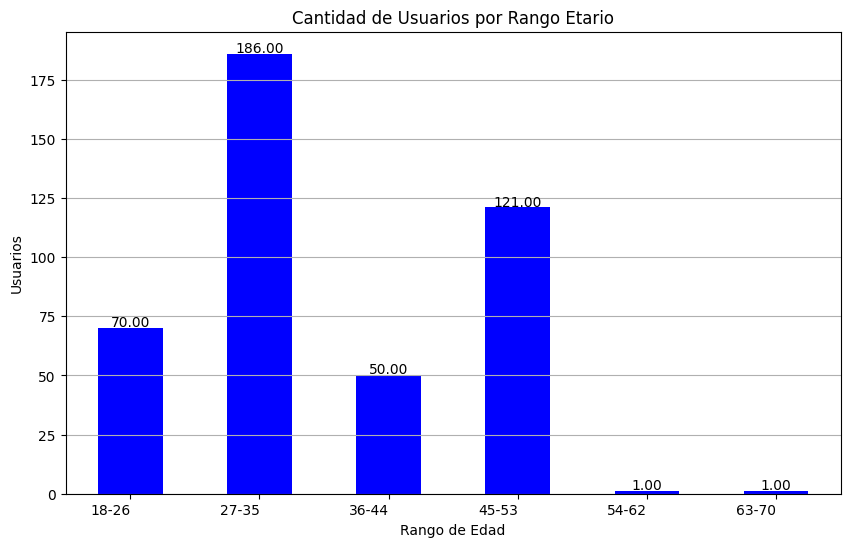

In [320]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = resultados.plot(kind='bar', color='blue')

# Personalizar el gráfico
plt.title('Cantidad de Usuarios por Rango Etario')
plt.xlabel('Rango de Edad')
plt.ylabel('Usuarios')
plt.grid(axis='y')

# Mostrar las cantidades sobre las barras
for p in ax.patches:
    ax.annotate(f"{p.get_height():,.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')
plt.xticks(rotation=0, ha="right")
plt.savefig('RangoEtario.png')

# Mostrar el gráfico
plt.show()

### 4-1 ¿cuál es su severidad promedio?

    - Para el calculo de la severidad, asumir que el deducible para las coberturas de daños materiales y robo total es de 5% sobre 100k del valor comercial del auto.

Consideraciones: 
Severidad es la sumatoria de todos los gastos del siniestro, después de restar los deducibles a los que aplique según las coberturas involucradas en el siniestro

Se calculara la severidad promedio para los usuarios con rango etario definido, con siniestros en la tabla service, que tenga valores diferentes a NaN o Cero.


In [321]:
#Unión de tablas service y people
merge_range_et_service=pd.merge(left=service,right=people_c2,left_on='people_id',right_on='id')

In [322]:
#Calculo de deducibles para las coberturas que aplique.

# Definir patrones, valor comercial del auto y porcentaje de la póliza.
patrones2 = ["Robo Total", "Daños materiales"]
commercial_value2 = 100000
porcentaje_aumento2 = 0.05

# Llamar a la función para buscar y actualizar en 'result_merge'
buscar_y_actualizar(merge_range_et_service, status, patrones2, commercial_value2, porcentaje_aumento2)

In [323]:
#Se eliminan los valores NaN asumiendo que estos son registros que no son gastos.
merge_range_et_service.dropna(subset=['amount'], inplace=True)

In [324]:
#Cantidad de servicios
merge_range_et_service.shape

(263, 36)

In [325]:
#Suma de siniestros por persona con deducibles aplicables.
Sum_niestros=merge_range_et_service.groupby(['people_id'])['amount'].sum().reset_index()
#Unión de la suma de siniestros  con la tabla people para tener el rango etario.
merge_range_et_siniestros=pd.merge(left=Sum_niestros,right=people_c2,left_on='people_id',right_on='id')
#Agrupar por rango etario y obtener el promedio.
Promedio=merge_range_et_siniestros.groupby(['age_group'])['amount'].mean().reset_index()
#De obtenerse valores nulos eliminarlos porque afectan al gráfico y no, nos sirven
Promedio.dropna(inplace=True)
#Convertir a str para poder gráficar.

Promedio['age_group'] = Promedio['age_group'].astype(str)


In [330]:
Promedio

,age_group,amount
0,18-26,"-1,078,611.52"
1,27-35,"-25,136,033.13"
2,36-44,"-62,171,242.40"
3,45-53,"-23,295,302.30"
4,54-62,"-5,000.00"


##### Gráfico para llenar el reporte en PDF

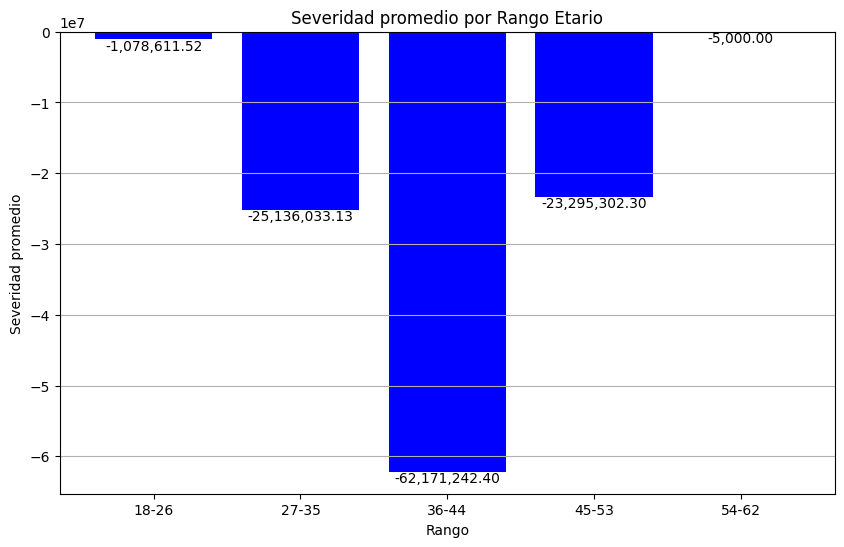

In [331]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = plt.bar(Promedio['age_group'], Promedio['amount'], color='blue')

# Personalizar el gráfico
plt.title('Severidad promedio por Rango Etario')
plt.xlabel('Rango')
plt.ylabel('Severidad promedio')
plt.grid(axis='y')

# Función para agregar etiquetas de valores en las barras
def autolabel(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval,
                 f'{yval:,.2f}',
                 ha='center', va='bottom' if yval > 0 else 'top', color='black')

# Agregar etiquetas de valores en las barras
autolabel(ax)

# Mostrar el gráfico
plt.savefig('Severidad_Etario.png')
plt.show()

In [333]:
#Para el PDF
Promedio['amount'] = Promedio['amount'].apply(lambda x: f'{x:,.2f}')
rango_prom_mayor=Promedio[Promedio['age_group']==mayor_cantidad].reset_index(drop=True)
rango_prom_mayor=f"{rango_prom_mayor['age_group'][0]}: {rango_prom_mayor['amount'][0][0:]}"
rango_prom_menor=Promedio[Promedio['age_group']==menor_cantidad].reset_index()
rango_prom_menor=f"{rango_prom_menor['age_group'][0]}: {rango_prom_menor['amount'][0][0:]}"

In [334]:
rango_prom_mayor

'27-35: -25,136,033.13'

In [335]:
rango_prom_menor

'54-62: -5,000.00'

### FUNCIÓN PARA LLENAR EL INFORME PDF

In [339]:
def create_pdf(result,max_sin,min_sin,max_sines,max_prom_sev,min_sines,min_prom_sev,rango_mayor,rango_menor,rango_prom_mayor,rango_prom_menor, output_filename='informe.pdf'):
    # Configurar el tamaño de la página (puedes cambiarlo según tus necesidades)
    width, height = letter

    # Crear el objeto PDF
    pdf_canvas = canvas.Canvas(output_filename, pagesize=letter)
    
    # Configurar el título del informe
    title = "Informe de Resultados"
    pdf_canvas.setFont("Helvetica", 16)
    pdf_canvas.drawString(width / 2 - pdf_canvas.stringWidth(title, "Helvetica", 16) / 2, height - 50, title)

    # Agregar datos al informe
    pdf_canvas.setFont("Helvetica", 12)
    y_position = height - 80
    
    #Siniestralidad Mensual de la compañía
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, "1.-Siniestralidad Mensual de la compañía:")
    y_position -= 20
    pdf_canvas.setFont("Helvetica", 12)
    for index in result.index:
    # Imprimir el índice
        pdf_canvas.drawString(100, y_position, f"{index}")
    # Imprimir la Siniestralidad_Mensual al lado del índice
        pdf_canvas.drawString(200, y_position, f"{result.loc[index, 'Siniestralidad_Mensual']}")
        y_position -= 20

    # Agregar una imagen al informe (reemplaza 'ruta_de_la_imagen' con la ruta de tu imagen)
    imagen_path = 'Siniestralidad_Mensual.png'
    pdf_canvas.drawInlineImage(imagen_path, 100, height - 400, width=400, height=200)

    y_position = height - 440
    #Cobertura con mayor cantidad de siniestros
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, "2.-Cobertura con Mayor Cantidad de Siniestros:")
    y_position -= 20
    pdf_canvas.setFont("Helvetica", 12)
    # Agregar título para los resultados en paralelo
    pdf_canvas.drawString(100, y_position, "Nombre")
    pdf_canvas.drawString(170, y_position, "Descripción")
    pdf_canvas.drawString(260, y_position, "No. Siniestros")
    y_position -= 20
    for index, row in max_sin.iterrows():
        pdf_canvas.drawString(100, y_position, f"{row['name']}")
        pdf_canvas.drawString(150, y_position, f"{row['description_y']}")
        pdf_canvas.drawString(280, y_position, f"{row['Siniestros']}")
        y_position -= 30
    
    y_position = height - 510
    #Cobertura con menor cantidad de siniestros
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, "2.2.-Cobertura con Menor Cantidad de Siniestros:")
    y_position -= 20
    pdf_canvas.setFont("Helvetica", 12)
    # Agregar título para los resultados en paralelo
    pdf_canvas.drawString(100, y_position, "Nombre")
    pdf_canvas.drawString(170, y_position, "Descripción")
    pdf_canvas.drawString(260, y_position, "No. Siniestros")
    y_position -= 20
    for index, row in min_sin.iterrows():
        pdf_canvas.drawString(100, y_position, f"{row['name']}")
        pdf_canvas.drawString(170, y_position, f"{row['description_y']}")
        pdf_canvas.drawString(280, y_position, f"{row['Siniestros']}")
        y_position -= 30
    
    # Agregar una imagen al informe (reemplaza 'ruta_de_la_imagen' con la ruta de tu imagen)
    imagen_path = 'Siniestros.png'
    pdf_canvas.drawInlineImage(imagen_path, 100, height - 760, width=400, height=200)

    pdf_canvas.showPage()

    y_position = height - 100

     #Mayor Siniestralidad por Partner
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, "3.-Partner con mayor siniestralidad:")
    y_position -= 20
    pdf_canvas.setFont("Helvetica", 12)
    for index in max_sines.index:
    # Imprimir el índice
        pdf_canvas.drawString(100, y_position, f"{index}")
    # Imprimir la Siniestralidad_Mensual al lado del índice
        pdf_canvas.drawString(200, y_position, f"{max_sines.loc[index, 'amount']}")
        y_position -= 20
    
        y_position = height - 140
    #Severidad Promedio para el partner con mayor Siniestralidad
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, "Promedio de severidad:")
    pdf_canvas.setFont("Helvetica", 12)
    y_position -= 20
    for index, row in max_prom_sev.iterrows():
        pdf_canvas.drawString(100, y_position, f"{row['policy_number']}")
        pdf_canvas.drawString(170, y_position, f"{row['amount']}")
        y_position -= 30
    
    y_position = height - 200
    #Menor Siniestralidad por Partner
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, "3.1.-Partner con menor siniestralidad:")
    y_position -= 20
    pdf_canvas.setFont("Helvetica", 12)
    for index in min_sines.index:
    # Imprimir el índice
        pdf_canvas.drawString(100, y_position, f"{index}")
    # Imprimir la Siniestralidad_Mensual al lado del índice
        pdf_canvas.drawString(200, y_position, f"{min_sines.loc[index, 'amount']}")
        y_position -= 30
    
        y_position = height - 250
    #Severidad Promedio para el partner con menor Siniestralidad
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, "Promedio de severidad:")
    pdf_canvas.setFont("Helvetica", 12)
    y_position -= 20
    for index, row in min_prom_sev.iterrows():
        pdf_canvas.drawString(100, y_position, f"{row['policy_number']}")
        pdf_canvas.drawString(170, y_position, f"{row['amount']}")
        y_position -= 30
    
    # Agregar una imagen al informe (reemplaza 'ruta_de_la_imagen' con la ruta de tu imagen)
    imagen_path = 'Siniestralidad_Partner.png'
    pdf_canvas.drawInlineImage(imagen_path, 100, height - 500, width=400, height=200)

    imagen_path = 'Siniestralidad_Promedio_Partner.png'
    pdf_canvas.drawInlineImage(imagen_path, 100, height - 700, width=400, height=200)

    pdf_canvas.showPage()

    y_position = height - 80
    
    #Rango etario 
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, f"4.-Rangos Etarios con mayor y menor cantidad de usuarios:")
    y_position -= 20
    pdf_canvas.setFont("Helvetica", 12)
    pdf_canvas.drawString(100, y_position, f"Rango etario mayor : {(rango_mayor)}")
    y_position -= 20
    pdf_canvas.drawString(100, y_position, f"Rango etario menor: {(rango_menor)}")
    
    imagen_path = 'RangoEtario.png'
    pdf_canvas.drawInlineImage(imagen_path, 100, height - 350, width=400, height=200)
    
    y_position -= 20
    pdf_canvas.setFont("Helvetica", 12)

    y_position = height - 380
    #Severidad Promedio para el partner con menor Siniestralidad
    pdf_canvas.setFont("Helvetica-Bold", 12)
    pdf_canvas.drawString(100, y_position, "4.1.-Promedio de severidad:")
    y_position -= 20
    pdf_canvas.setFont("Helvetica", 12)
    pdf_canvas.drawString(100, y_position, f"Rango etario mayor : {(rango_prom_mayor)}")
    y_position -= 20
    pdf_canvas.drawString(100, y_position, f"Rango etario menor: {(rango_prom_menor)}")
    y_position -= 20

    y_position = height - 500
    
    imagen_path = 'Severidad_Etario.png'
    pdf_canvas.drawInlineImage(imagen_path, 100, height - 650, width=400, height=200)
    
    # Guardar el PDF
    pdf_canvas.save()

# Llamar a la función para crear el informe PDF
create_pdf(result,mayor_cantidad_siniestros,menor_cantidad_siniestros,mayor_sinestrialidad,prom_partner_max,menor_sinestrialidad,prom_partner_min,mayor_cantidad,menor_cantidad,rango_prom_mayor,rango_prom_menor)